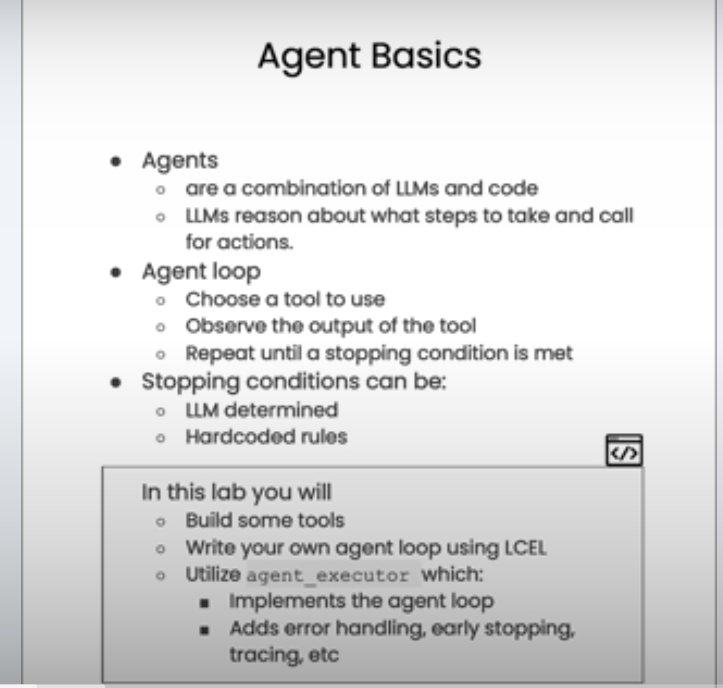

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
from langchain.tools import tool

In [3]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

In [4]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [5]:
tools = [get_current_temperature,search_wikipedia]

In [6]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [7]:
functions = [format_tool_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

C:\Users\Lalith Rao\AppData\Local\Temp\ipykernel_34516\390516792.py:1: LangChainDeprecationWarning: The function `_format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 1.0. Use :meth:`~langchain_core.utils.function_calling.convert_to_openai_function()` instead.
  functions = [format_tool_to_openai_function(f) for f in tools]
C:\Users\Lalith Rao\AppData\Local\Temp\ipykernel_34516\390516792.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(temperature=0).bind(functions=functions)


In [8]:
result = chain.invoke({"input": "what is the weather is sf?"})
result.tool

'get_current_temperature'

In [9]:
result.tool_input

{'latitude': 37.7749, 'longitude': -122.4194}

In [10]:
from langchain.prompts import MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [11]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [12]:
result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": []
})

In [13]:
result1.tool

'get_current_temperature'

In [14]:
observation = get_current_temperature(result1.tool_input)
observation

C:\Users\Lalith Rao\AppData\Local\Temp\ipykernel_34516\3700062716.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  observation = get_current_temperature(result1.tool_input)
C:\Users\Lalith Rao\AppData\Local\Temp\ipykernel_34516\4059959254.py:32: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_utc_time = datetime.datetime.utcnow()


'The current temperature is 12.7°C'

In [15]:
type(result1)

langchain_core.agents.AgentActionMessageLog

In [16]:
from langchain.agents.format_scratchpad import format_to_openai_functions

In [17]:
result1.message_log

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{"latitude":37.7749,"longitude":-122.4194}'}}, response_metadata={'token_usage': <OpenAIObject at 0x2983a82b020> JSON: {
   "prompt_tokens": 112,
   "completion_tokens": 26,
   "total_tokens": 138,
   "prompt_tokens_details": {
     "cached_tokens": 0,
     "audio_tokens": 0
   },
   "completion_tokens_details": {
     "reasoning_tokens": 0,
     "audio_tokens": 0,
     "accepted_prediction_tokens": 0,
     "rejected_prediction_tokens": 0
   }
 }, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-8078a691-5d54-4064-a535-0ed8e596f4eb-0')]

In [18]:
format_to_openai_functions([(result1, observation), ])

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{"latitude":37.7749,"longitude":-122.4194}'}}, response_metadata={'token_usage': <OpenAIObject at 0x2983a82b020> JSON: {
   "prompt_tokens": 112,
   "completion_tokens": 26,
   "total_tokens": 138,
   "prompt_tokens_details": {
     "cached_tokens": 0,
     "audio_tokens": 0
   },
   "completion_tokens_details": {
     "reasoning_tokens": 0,
     "audio_tokens": 0,
     "accepted_prediction_tokens": 0,
     "rejected_prediction_tokens": 0
   }
 }, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'function_call', 'logprobs': None}, id='run-8078a691-5d54-4064-a535-0ed8e596f4eb-0'),
 FunctionMessage(content='The current temperature is 12.7°C', additional_kwargs={}, response_metadata={}, name='get_current_temperature')]

In [19]:
result2 = chain.invoke({
    "input": "what is the weather is sf?", 
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])
})

In [20]:
result2

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 12.7°C.'}, log='The current temperature in San Francisco is 12.7°C.')

In [21]:
from langchain.schema.agent import AgentFinish
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = chain.invoke({
            "input": user_input, 
            "agent_scratchpad": format_to_openai_functions(intermediate_steps)
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [22]:
from langchain.schema.runnable import RunnablePassthrough
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain

In [23]:
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input, 
            "intermediate_steps": intermediate_steps
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [24]:
run_agent("what is the weather is sf?")

C:\Users\Lalith Rao\AppData\Local\Temp\ipykernel_34516\4059959254.py:32: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_utc_time = datetime.datetime.utcnow()


AgentFinish(return_values={'output': 'The current temperature in San Francisco is 12.5°C.'}, log='The current temperature in San Francisco is 12.5°C.')

In [26]:
run_agent("what is langchain?")

AgentFinish(return_values={'output': 'I couldn\'t find specific information on "Langchain." It seems like it may not be a widely recognized term or topic. If you have any other questions or need assistance with something else, feel free to ask!'}, log='I couldn\'t find specific information on "Langchain." It seems like it may not be a widely recognized term or topic. If you have any other questions or need assistance with something else, feel free to ask!')

In [27]:
run_agent("hi")

AgentFinish(return_values={'output': 'Well, hello there! How can I assist you today?'}, log='Well, hello there! How can I assist you today?')

In [28]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

In [29]:

agent_executor.invoke({"input": "what is langchain?"})



> Entering new AgentExecutor chain...

Invoking: `search_wikipedia` with `{'query': 'Langchain'}`


Page: LangChain
Summary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

Page: Milvus (vector database)
Summary: Milvus is a distributed vector database developed by Zilliz. It is available as both open-source software and a cloud service.
Milvus is an open-source project under LF AI & Data Foundation distributed under the Apache License 2.0.



Page: Intelligent agent
Summary: In artificial intelligence, an intelligent agent is an entity that perceives its environment, takes actions autonomously to achieve goals, and may improve its performance through machine learning or by acquiring knowledge. Leading AI textbook

{'input': 'what is langchain?',
 'output': 'I couldn\'t find specific information on "Langchain." It seems like it may not be a widely recognized term or topic. If you have any other questions or need assistance with something else, feel free to ask!'}

In [30]:
agent_executor.invoke({"input": "my name is bob"})



> Entering new AgentExecutor chain...
Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [31]:

agent_executor.invoke({"input": "what is my name"})



> Entering new AgentExecutor chain...
I'm sorry, I don't have access to your personal information. How can I assist you today?

> Finished chain.


{'input': 'what is my name',
 'output': "I'm sorry, I don't have access to your personal information. How can I assist you today?"}

In [32]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [33]:
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | prompt | model | OpenAIFunctionsAgentOutputParser()

In [34]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")

C:\Users\Lalith Rao\AppData\Local\Temp\ipykernel_34516\4052124774.py:2: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")


In [35]:
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True, memory=memory)

In [36]:
agent_executor.invoke({"input": "my name is bob"})



> Entering new AgentExecutor chain...
Nice to meet you, Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'chat_history': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?', additional_kwargs={}, response_metadata={})],
 'output': 'Nice to meet you, Bob! How can I assist you today?'}

In [37]:
agent_executor.invoke({"input": "whats my name"})



> Entering new AgentExecutor chain...
Your name is Bob.

> Finished chain.


{'input': 'whats my name',
 'chat_history': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='whats my name', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Your name is Bob.', additional_kwargs={}, response_metadata={})],
 'output': 'Your name is Bob.'}

In [38]:
agent_executor.invoke({"input": "whats the weather in sf?"})



> Entering new AgentExecutor chain...

Invoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`




C:\Users\Lalith Rao\AppData\Local\Temp\ipykernel_34516\4059959254.py:32: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  current_utc_time = datetime.datetime.utcnow()


The current temperature is 13.9°CThe current temperature in San Francisco is 13.9°C.

> Finished chain.


{'input': 'whats the weather in sf?',
 'chat_history': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Nice to meet you, Bob! How can I assist you today?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='whats my name', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Your name is Bob.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='whats the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The current temperature in San Francisco is 13.9°C.', additional_kwargs={}, response_metadata={})],
 'output': 'The current temperature in San Francisco is 13.9°C.'}

# Chatbot

In [39]:
@tool
def create_your_own(query: str) -> str:
    """This function can do whatever you would like once you fill it in """
    print(type(query))
    return query[::-1]

In [40]:
tools = [get_current_temperature, search_wikipedia, create_your_own]

In [ ]:
import panel as pn  # GUI
pn.extension()
import panel as pn
import param

class cbfs(param.Parameterized):
    
    def __init__(self, tools, **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.functions = [format_tool_to_openai_function(f) for f in tools]
        self.model = ChatOpenAI(temperature=0).bind(functions=self.functions)
        self.memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", "You are helpful but sassy assistant"),
            MessagesPlaceholder(variable_name="chat_history"),
            ("user", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        self.chain = RunnablePassthrough.assign(
            agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"])
        ) | self.prompt | self.model | OpenAIFunctionsAgentOutputParser()
        self.qa = AgentExecutor(agent=self.chain, tools=tools, verbose=False, memory=self.memory)
    
    def convchain(self, query):
        if not query:
            return
        inp.value = ''
        result = self.qa.invoke({"input": query})
        self.answer = result['output'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=450)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=450, styles={'background-color': '#F6F6F6'}))
        ])
        return pn.WidgetBox(*self.panels, scroll=True)


    def clr_history(self,count=0):
        self.chat_history = []
        return

In [ ]:
cb = cbfs(tools)

inp = pn.widgets.TextInput( placeholder='Enter text here…')

conversation = pn.bind(cb.convchain, inp) 

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=400),
    pn.layout.Divider(),
)

dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# QnA_Bot')),
    pn.Tabs(('Conversation', tab1))
)


BokehModel(combine_events=True, render_bundle={'docs_json': {'b00c7d93-32c1-4979-b231-14632553ab77': {'version…

In [ ]:
dashboard